# Reproduction of nipype's tutorial example on finger-foot-lips dataset using FSL FEAT 

The pipelines were adapted on a dataset downloadable [**here**](https://openneuro.org/datasets/ds000114/versions/1.0.1). 

To use the notebooks, create a docker container using the instructions in the file and use the parent repository of **"analytic_variability_fmri"** as a volume. The dataset should be downloaded in a repository named **"tutorial_data"** in the directory **"data"** inside this repository. 
Otherwise, if you want to use different paths, you need to update these paths on the notebooks. 

This notebook is separated into **2 parts** : 
* Preprocessing
* 1st level analysis 

The first part can be run by its own but the 1st level analysis require that the preprocessing was already run. 

In [1]:
# Set the path to matlab 
## NECESSARY TO USE SPM
from nipype.interfaces import spm
matlab_cmd = '/opt/spm12-r7771/run_spm12.sh /opt/matlabmcr-2010a/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

In [2]:
from nipype.interfaces.fsl import (Info, BET, ExtractROI, FAST, FLIRT, ImageMaths, IsotropicSmooth, FNIRT, ApplyWarp,
                                   MCFLIRT, SliceTimer, Threshold, Level1Design, FEATModel, FILMGLS)
from nipype.algorithms.modelgen import SpecifyModel
from nipype.interfaces.spm import Smooth
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.utility import IdentityInterface, Function
from nipype import Workflow, Node

from nilearn import plotting
%matplotlib inline

from os.path import join as opj
import os
import json

In [3]:
# REPOSITORIES TO FIND & STORE FILES 
## exp_dir : where the results files will be stored and where the data files are stored
## working_dir : where the intermediate results files will be stored (inside exp_dir)
## output_dir : where the final results files (the one you connect to datasink) will be stored inside exp_dir
exp_dir = '/home/analytic_variability_fmri/data/tutorial_data'
working_dir = 'workingdir_fsl'
output_dir = 'datasink_fsl'

In [42]:
# BASIC VARIABLES
# list of subject identifiers (to simplify the execution, we decided to use only one subject)
# group analysis will be performed in an other notebook
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# list of session identifiers
task_list = ['fingerfootlips']

# Smoothing widths to apply
fwhm = 8


# TR of functional images
with open('/home/analytic_variability_fmri/data/tutorial_data/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

iso_size = 4

# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ('average',        'T', condition_names, [1/3., 1/3., 1/3.])
cont02 = ('Finger',         'T', condition_names, [1, 0, 0])
cont03 = ('Foot',           'T', condition_names, [0, 1, 0])
cont04 = ('Lips',           'T', condition_names, [0, 0, 1])
cont05 = ('Finger > others','T', condition_names, [1, -0.5, -0.5])
cont06 = ('Foot > others',  'T', condition_names, [-0.5, 1, -0.5])
cont07 = ('Lips > others',  'T', condition_names, [-0.5, -0.5, 1])

contrasts = [cont01, cont02, cont03, cont04, cont05, cont06, cont07]

In [5]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")

infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'ses-test', 'anat', 'sub-{subject_id}_ses-test_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'ses-test', 'func', 'sub-{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat' : anat_file, 'func' : func_file}

selectfiles = Node(SelectFiles(templates, base_directory=exp_dir),
                   name="selectfiles")

In [6]:
# Datasink node : to save important files 
datasink = Node(DataSink(base_directory = exp_dir, container = output_dir), name = 'datasink')

In [7]:
target_brain_img = Info.standard_image("avg152T1_brain.nii.gz")
target_img = Info.standard_image("avg152T1.nii.gz")
config_file = 'T1_2_MNI152_2mm'
target_mask = Info.standard_image("MNI152_T1_2mm_brain_mask_dil.nii.gz")

coreg_wf = Workflow(name="coreg_wf", base_dir = opj(exp_dir, working_dir))

bet_anat = Node(BET(), name='bet_anat')

segmentation = Node(FAST(), name='segmentation')

# Select white matter segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin'),
                name="threshold")

mean2anat = Node(FLIRT(dof = 6), name='mean2anat')


mean2anat_bbr = Node(FLIRT(dof = 6, cost = 'bbr', schedule = opj( os.getenv('FSLDIR'), 'etc/flirtsch/bbr.sch')),
                    name='mean2anat_bbr')

anat2target_affine = Node(FLIRT(reference = target_brain_img), name='anat2target_affine')

anat2target_nonlinear = Node(FNIRT(fieldcoeff_file = True,
                                  ref_file = target_img, 
                                  config_file = config_file,
                                  refmask_file=target_mask), name='anat2target_nonlinear')


warpmean = Node(ApplyWarp(interp='spline', ref_file = target_img), name='warpmean')


warpall = Node(ApplyWarp(interp='spline', ref_file = target_img), name='warpall')

coreg_wf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm), 'in_file')]),
                 (bet_anat, mean2anat, [('out_file', 'reference')]),
                 (bet_anat, anat2target_affine, [('out_file', 'in_file')]),
                 (threshold, mean2anat_bbr, [('out_file', 'wm_seg')]),
                 (mean2anat, mean2anat_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (anat2target_affine, anat2target_nonlinear, [('out_matrix_file', 'affine_file')]),
                 (anat2target_nonlinear, warpmean, [('fieldcoeff_file', 'field_file')]),
                 (anat2target_nonlinear, warpall, [('fieldcoeff_file', 'field_file')]),
                 (mean2anat_bbr, warpmean, [('out_matrix_file', 'premat')]),
                 (mean2anat_bbr, warpall, [('out_matrix_file', 'premat')])])

In [8]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")


# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# Smooth - image smoothing
smooth = Node(IsotropicSmooth(fwhm = fwhm), name="smooth")

In [9]:
# Create a preprocessing workflow
preprocess = Workflow(name='preprocess')
preprocess.base_dir = opj(exp_dir, working_dir)

# Connect all components of the preprocessing workflow
preprocess.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, slicetimer, [('roi_file', 'in_file')]),
                 (slicetimer, mcflirt, [('slice_time_corrected_file', 'in_file')]),

                 (selectfiles, coreg_wf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'mean2anat_bbr.reference'),
                                         ('anat', 'anat2target_nonlinear.in_file')]),
                 (mcflirt, coreg_wf, [('mean_img', 'mean2anat.in_file'),
                                     ('mean_img', 'mean2anat_bbr.in_file'),
                                     ('mean_img', 'warpmean.in_file'),
                                     ('out_file', 'warpall.in_file')]),

                 (coreg_wf, smooth, [('warpall.out_file', 'in_file')]),

                 (mcflirt, datasink, [('par_file', 'preprocess.par')]),
                 (smooth, datasink, [('out_file', 'preprocess.smooth')]),
                    
                 (coreg_wf, datasink, [('mean2anat_bbr.out_matrix_file', 'preprocess.mean_mat_file'),
                                      ('bet_anat.out_file', 'preprocess.anat_brain'),
                                      ('anat2target_nonlinear.fieldcoeff_file', 'preprocess.fieldcoeff_file')]),
                 ])

In [10]:
# Create preprocess output graph
preprocess.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preprocess.base_dir, 'preprocess', 'graph.png'))

210302-18:43:07,503 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/graph.png (graph2use=colored, simple_form=True).


In [11]:
preprocess.run('MultiProc', plugin_args={'n_procs': 2})

210302-18:43:10,482 nipype.workflow INFO:
	 Workflow preprocess settings: ['check', 'execution', 'logging', 'monitoring']
210302-18:43:10,561 nipype.workflow INFO:
	 Running in parallel.
210302-18:43:10,565 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 13.96/13.96, Free processors: 2/2.
210302-18:43:10,644 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_09_task_name_fingerfootlips/selectfiles".
210302-18:43:10,642 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_10_task_name_fingerfootlips/selectfiles".
210302-18:43:10,651 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210302-18:43:10,655 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
2103

210302-18:46:46,787 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 10 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.coreg_wf.mean2anat
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-18:46:54,506 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.mean2anat".
210302-18:46:54,794 nipype.workflow INFO:
	 [Job 9] Completed (preprocess.coreg_wf.mean2anat).
210302-18:46:54,796 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 11 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-18:46:54,846 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.mean2anat_bbr" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_10_task_name_fingerfootlips/mean2anat_bbr".
210302-18

210302-18:51:35,147 nipype.workflow INFO:
	 [Node] Running "warpall" ("nipype.interfaces.fsl.preprocess.ApplyWarp"), a CommandLine Interface with command:
applywarp --in=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_10_task_name_fingerfootlips/mcflirt/sub-10_ses-test_task-fingerfootlips_bold_roi_st_mcf.nii --ref=/opt/fsl-6.0.3/data/standard/avg152T1.nii.gz --out=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_10_task_name_fingerfootlips/warpall/sub-10_ses-test_task-fingerfootlips_bold_roi_st_mcf_warp.nii.gz --warp=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_10_task_name_fingerfootlips/anat2target_nonlinear/sub-10_ses-test_T1w_fieldwarp.nii.gz --premat=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_10_task_name_fingerfootlips/mean2anat_bbr/sub-10_ses-test_task-fingerfootlips_bold_roi_st_mcf_m

210302-18:55:57,426 nipype.workflow INFO:
	 [Node] Running "slicetimer" ("nipype.interfaces.fsl.preprocess.SliceTimer"), a CommandLine Interface with command:
slicetimer --in=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_09_task_name_fingerfootlips/extract/sub-09_ses-test_task-fingerfootlips_bold_roi.nii --odd --out=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_09_task_name_fingerfootlips/slicetimer/sub-09_ses-test_task-fingerfootlips_bold_roi_st.nii --repeat=2.500000
210302-18:55:59,370 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 8 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.slicetimer
                       * preprocess.coreg_wf.segmentation
210302-18:56:02,207 nipype.workflow INFO:
	 [Node] Finished "preprocess.slicetimer".
210302-18:56:03,372 nipype.workflow INFO:
	 [Job 22] Completed (pre

210302-18:57:49,547 nipype.workflow INFO:
	 [Node] Running "threshold" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_09_task_name_fingerfootlips/segmentation/sub-09_ses-test_T1w_brain_pve_2.nii.gz -thr 0.5000000000 -bin /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_09_task_name_fingerfootlips/threshold/sub-09_ses-test_T1w_brain_pve_2_thresh.nii.gz
210302-18:57:50,392 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.threshold".
210302-18:57:51,482 nipype.workflow INFO:
	 [Job 20] Completed (preprocess.coreg_wf.threshold).
210302-18:57:51,484 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 10 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.anat2target_affine
210302-18:57:51,54

210302-19:03:01,890 nipype.workflow INFO:
	 [Node] Finished "preprocess.smooth".
210302-19:03:03,794 nipype.workflow INFO:
	 [Job 27] Completed (preprocess.smooth).
210302-19:03:03,795 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 11 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-19:03:03,846 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.datasink" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_09_task_name_fingerfootlips/datasink".
210302-19:03:03,854 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
210302-19:03:03,859 nipype.workflow INFO:
	 [Node] Finished "preprocess.datasink".
210302-19:03:05,796 nipype.workflow INFO:
	 [Job 28] Completed (preprocess.datasink).
210302-19:03:05,799 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 10 jobs ready. Fr

210302-19:04:57,958 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.mean2anat" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_08_task_name_fingerfootlips/mean2anat".
210302-19:04:57,962 nipype.workflow INFO:
	 [Node] Running "mean2anat" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_08_task_name_fingerfootlips/mcflirt/sub-08_ses-test_task-fingerfootlips_bold_roi_st_mcf_mean_reg.nii -ref /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_08_task_name_fingerfootlips/bet_anat/sub-08_ses-test_T1w_brain.nii.gz -out sub-08_ses-test_task-fingerfootlips_bold_roi_st_mcf_mean_reg_flirt.nii.gz -omat sub-08_ses-test_task-fingerfootlips_bold_roi_st_mcf_mean_reg_flirt.mat -dof 6
210302-19:04:59,910 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, an

210302-19:05:52,758 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.threshold".
210302-19:05:53,965 nipype.workflow INFO:
	 [Job 35] Completed (preprocess.coreg_wf.threshold).
210302-19:05:53,966 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 9 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-19:05:54,19 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.mean2anat_bbr" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_08_task_name_fingerfootlips/mean2anat_bbr".
210302-19:05:54,25 nipype.workflow INFO:
	 [Node] Running "mean2anat_bbr" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_08_task_name_fingerfootlips/mcflirt/sub-08_ses-test_task-finge

210302-19:10:16,227 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 7 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
                       * preprocess.smooth
210302-19:11:08,75 nipype.workflow INFO:
	 [Node] Finished "preprocess.smooth".
210302-19:11:08,280 nipype.workflow INFO:
	 [Job 42] Completed (preprocess.smooth).
210302-19:11:08,282 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 8 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:11:08,337 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.datasink" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_08_task_name_fingerfootlips/datasink".
210302-19:11:08,345 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.

210302-19:12:36,367 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 6 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.coreg_wf.bet_anat
                       * preprocess.coreg_wf.segmentation
210302-19:12:39,908 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.bet_anat".
210302-19:12:40,371 nipype.workflow INFO:
	 [Job 61] Completed (preprocess.coreg_wf.bet_anat).
210302-19:12:40,373 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 8 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:12:40,423 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.anat2target_affine" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_06_task_name_fingerfootlips/anat2target_affine".
210302-19:12:40,428 n

210302-19:13:42,433 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 8 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.coreg_wf.warpall
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-19:16:40,149 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.warpall".
210302-19:16:40,608 nipype.workflow INFO:
	 [Job 56] Completed (preprocess.coreg_wf.warpall).
210302-19:16:40,610 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 9 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-19:16:40,671 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.smooth" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_07_task_name_fingerfootlips/smooth".
210302-19:16:40,675 nipype.workflow INFO:
	 [Nod

210302-19:18:46,735 nipype.workflow INFO:
	 [Job 67] Completed (preprocess.slicetimer).
210302-19:18:46,737 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 6 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:18:46,788 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.mcflirt" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_06_task_name_fingerfootlips/mcflirt".
210302-19:18:46,793 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_06_task_name_fingerfootlips/slicetimer/sub-06_ses-test_task-fingerfootlips_bold_roi_st.nii -meanvol -out /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_06_task_

210302-19:20:40,849 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 6 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.coreg_wf.anat2target_nonlinear
                       * preprocess.coreg_wf.segmentation
210302-19:20:51,745 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.segmentation".
210302-19:20:52,861 nipype.workflow INFO:
	 [Job 64] Completed (preprocess.coreg_wf.segmentation).
210302-19:20:52,862 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 7 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-19:20:52,912 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.threshold" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_06_task_name_fingerfootlips/threshold".
210302-19

210302-19:24:57,101 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 5 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
                       * preprocess.coreg_wf.warpall
210302-19:25:00,846 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.warpall".
210302-19:25:01,105 nipype.workflow INFO:
	 [Job 71] Completed (preprocess.coreg_wf.warpall).
210302-19:25:01,109 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 6 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:25:01,180 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.smooth" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_06_task_name_fingerfootlips/smooth".
210302-19:25:01,186 nipype.workflow INFO:
	 [Node] Running "smooth

210302-19:27:41,340 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.mean2anat" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_05_task_name_fingerfootlips/mean2anat".
210302-19:27:41,341 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_04_task_name_fingerfootlips/selectfiles".
210302-19:27:41,344 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210302-19:27:41,347 nipype.workflow INFO:
	 [Node] Running "mean2anat" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_05_task_name_fingerfootlips/mcflirt/sub-05_ses-test_task-fingerfootlips_bold_roi_st_mcf_mean_reg.nii -ref /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preproce

210302-19:28:42,662 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.mean2anat_bbr".
210302-19:28:43,328 nipype.workflow INFO:
	 [Job 85] Completed (preprocess.coreg_wf.mean2anat_bbr).
210302-19:28:43,330 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 7 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-19:28:43,380 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.warpall" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_05_task_name_fingerfootlips/warpall".
210302-19:28:43,386 nipype.workflow INFO:
	 [Node] Running "warpall" ("nipype.interfaces.fsl.preprocess.ApplyWarp"), a CommandLine Interface with command:
applywarp --in=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_05_task_name_fingerfootlips/mcflirt/sub-05_ses-test_task-fing

210302-19:33:00,217 nipype.workflow INFO:
	 [Node] Finished "preprocess.extract".
210302-19:33:01,589 nipype.workflow INFO:
	 [Job 96] Completed (preprocess.extract).
210302-19:33:01,591 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 4 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:33:01,642 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.slicetimer" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_04_task_name_fingerfootlips/slicetimer".
210302-19:33:01,648 nipype.workflow INFO:
	 [Node] Running "slicetimer" ("nipype.interfaces.fsl.preprocess.SliceTimer"), a CommandLine Interface with command:
slicetimer --in=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_04_task_name_fingerfootlips/extract/sub-04_ses-test_task-fingerfootlips_bold_roi.nii --odd --out=/home/anal

210302-19:35:01,710 nipype.workflow INFO:
	 [Job 107] Completed (preprocess.coreg_wf.anat2target_affine).
210302-19:35:01,712 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 5 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:35:01,769 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.anat2target_nonlinear" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_03_task_name_fingerfootlips/anat2target_nonlinear".
210302-19:35:01,775 nipype.workflow INFO:
	 [Node] Running "anat2target_nonlinear" ("nipype.interfaces.fsl.preprocess.FNIRT"), a CommandLine Interface with command:
fnirt --aff=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_03_task_name_fingerfootlips/anat2target_affine/sub-03_ses-test_T1w_brain_flirt.mat --config=T1_2_MNI152_2mm --cout=/h

210302-19:39:11,963 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 5 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.smooth
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-19:39:28,594 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.anat2target_nonlinear".
210302-19:39:29,980 nipype.workflow INFO:
	 [Job 108] Completed (preprocess.coreg_wf.anat2target_nonlinear).
210302-19:39:29,982 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 5 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.smooth
210302-19:39:30,33 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.warpmean" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_04_task_name_fingerfootlips/warpmean".
210302-19:39:30,40 nipype.workfl

210302-19:41:50,127 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 3 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:41:50,176 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.mean2anat" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_03_task_name_fingerfootlips/mean2anat".
210302-19:41:50,182 nipype.workflow INFO:
	 [Node] Running "mean2anat" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_03_task_name_fingerfootlips/mcflirt/sub-03_ses-test_task-fingerfootlips_bold_roi_st_mcf_mean_reg.nii -ref /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_03_task_name_fingerfootlips/bet_anat/sub-03_ses-test_T1w_brain.nii

210302-19:42:34,466 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.anat2target_affine".
210302-19:42:36,172 nipype.workflow INFO:
	 [Job 122] Completed (preprocess.coreg_wf.anat2target_affine).
210302-19:42:36,173 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 4 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.mean2anat_bbr
210302-19:42:36,224 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.anat2target_nonlinear" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_02_task_name_fingerfootlips/anat2target_nonlinear".
210302-19:42:36,230 nipype.workflow INFO:
	 [Node] Running "anat2target_nonlinear" ("nipype.interfaces.fsl.preprocess.FNIRT"), a CommandLine Interface with command:
fnirt --aff=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_02_task_name_f

210302-19:47:28,475 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 2 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
                       * preprocess.smooth
210302-19:47:28,507 nipype.workflow INFO:
	 [Node] Finished "preprocess.smooth".
210302-19:47:30,477 nipype.workflow INFO:
	 [Job 117] Completed (preprocess.smooth).
210302-19:47:30,479 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 3 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:47:30,555 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.datasink" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_03_task_name_fingerfootlips/datasink".
210302-19:47:30,563 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.i

210302-19:48:58,569 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.coreg_wf.bet_anat
                       * preprocess.coreg_wf.segmentation
210302-19:49:00,19 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.bet_anat".
210302-19:49:00,570 nipype.workflow INFO:
	 [Job 136] Completed (preprocess.coreg_wf.bet_anat).
210302-19:49:00,572 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 3 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:49:00,623 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.coreg_wf.anat2target_affine" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_01_task_name_fingerfootlips/anat2target_affine".
210302-19:49:00,628 n

210302-19:50:54,686 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 3 jobs ready. Free memory (GB): 13.56/13.96, Free processors: 0/2.
                     Currently running:
                       * preprocess.coreg_wf.warpall
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-19:53:50,827 nipype.workflow INFO:
	 [Node] Finished "preprocess.coreg_wf.warpall".
210302-19:53:50,861 nipype.workflow INFO:
	 [Job 131] Completed (preprocess.coreg_wf.warpall).
210302-19:53:50,862 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 4 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.anat2target_nonlinear
210302-19:53:50,915 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.smooth" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_02_task_name_fingerfootlips/smooth".
210302-19:53:50,918 nipype.workflow INFO:
	 [No

210302-19:56:15,5 nipype.workflow INFO:
	 [Job 142] Completed (preprocess.slicetimer).
210302-19:56:15,7 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * preprocess.coreg_wf.segmentation
210302-19:56:15,58 nipype.workflow INFO:
	 [Node] Setting-up "preprocess.mcflirt" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_01_task_name_fingerfootlips/mcflirt".
210302-19:56:15,62 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_01_task_name_fingerfootlips/slicetimer/sub-01_ses-test_task-fingerfootlips_bold_roi_st.nii -meanvol -out /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_01_task_name_

210302-19:58:49,243 nipype.workflow INFO:
	 [Node] Running "warpall" ("nipype.interfaces.fsl.preprocess.ApplyWarp"), a CommandLine Interface with command:
applywarp --in=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/_subject_id_01_task_name_fingerfootlips/mcflirt/sub-01_ses-test_task-fingerfootlips_bold_roi_st_mcf.nii --ref=/opt/fsl-6.0.3/data/standard/avg152T1.nii.gz --out=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_01_task_name_fingerfootlips/warpall/sub-01_ses-test_task-fingerfootlips_bold_roi_st_mcf_warp.nii.gz --warp=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_01_task_name_fingerfootlips/anat2target_nonlinear/sub-01_ses-test_T1w_fieldwarp.nii.gz --premat=/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/preprocess/coreg_wf/_subject_id_01_task_name_fingerfootlips/mean2anat_bbr/sub-01_ses-test_task-fingerfootlips_bold_roi_st_mcf_m

## END OF THE PREPROCESSING PIPELINE 

## BEGINNING OF ANALYSIS PIPELINE

In [43]:
def subjectinfo(subject_id):
    '''
    Function to get trial informations (conditions, onsets, durations) from a specific file.
    '''
    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/home/analytic_variability_fmri/data/tutorial_data/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10))
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations
                         )]

    return subject_info  # this output will later be returned to infosource

In [44]:
# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

In [45]:
# Infosource - a function free node to iterate over the list of subject names
infosource_analysis = Node(IdentityInterface(fields=['subject_id', 'contrasts'],
                                    contrasts=contrasts),
                  name="infosource_analysis")

infosource_analysis.iterables = [('subject_id', subject_list)]

# SelectFiles - to select necessary data 
## smooth corresponds to smoothed files obtained previously with preprocessing
## mc_param corresponds to motion correction parameters that can be added to the model
templates = {'smooth': opj(output_dir, 'preprocess', 'smooth','_subject_id_{subject_id}_task_name_{task_id}',
                         'sub-{subject_id}_ses-test_task-{task_id}_bold_roi_st_mcf_warp_smooth.nii.gz'),
            'mc_param' : opj(output_dir, 'preprocess', 'par', '_subject_id_{subject_id}_task_name_{task_id}',
                             'sub-{subject_id}_ses-test_task-{task_id}_bold_roi_st_mcf.nii.par')}

selectfiles_analysis = Node(SelectFiles(templates, base_directory= exp_dir),
                   name="selectfiles_analysis")

selectfiles_analysis.inputs.task_id = 'fingerfootlips'

In [46]:
datasink_analysis = Node(DataSink(base_directory = exp_dir, container=output_dir),
                         name = 'datasink_analysis')

In [47]:
specify_model = Node(SpecifyModel(high_pass_filter_cutoff = 128,
                                 input_units = 'secs',
                                 time_repetition = TR, 
                                 parameter_source='FSL'), name = 'specify_model')

l1_design = Node(Level1Design(bases = {'dgamma':{'derivs' : True}},
                             interscan_interval = TR, 
                             model_serial_correlations = True,
                             contrasts = contrasts), name = 'l1_design')

model_generation = Node(FEATModel(), name = 'model_generation')

model_estimate = Node(FILMGLS(smooth_autocorr=True, mask_size=5, threshold=1000),
                      name='model_estimate')

In [48]:
analysis = Workflow(base_dir = opj(exp_dir, working_dir), 
                                   name = 'analysis')

In [49]:
analysis.connect([(infosource_analysis, selectfiles_analysis, [('subject_id', 'subject_id')]),
                  (infosource_analysis, getsubjectinfo, [('subject_id','subject_id')]),
                  (getsubjectinfo, specify_model, [('subject_info', 'subject_info')]),
                  (selectfiles_analysis, specify_model, [('smooth', 'functional_runs'),
                                                        ('mc_param', 'realignment_parameters')]),
                  (infosource_analysis, l1_design, [('contrasts', 'contrasts')]),
                  (specify_model, l1_design, [('session_info', 'session_info')]),
                  (l1_design, model_generation, [('fsf_files', 'fsf_file'),
                                                 ('ev_files', 'ev_files')]),
                  (selectfiles_analysis, model_estimate, [('smooth', 'in_file')]),
                  (model_generation, model_estimate, [('design_file', 'design_file'),
                                                     ('con_file', 'tcon_file'),
                                                     ('fcon_file', 'fcon_file')]),
                  (model_generation, datasink_analysis, [('design_image', 'results.generation.@img'),
                                                      ('con_file', 'results.generation.@con_file')]),
                  (model_estimate, datasink_analysis, [('param_estimates', 'results.estimate.@param_estimate'),
                                                      ('copes', 'results.estimate.@copes'),
                                                      ('varcopes', 'results.estimate.@varcopes'),
                                                      ('zstats', 'results.estimate.@zstats'),
                                                      ('tstats', 'results.estimate.@tstats'),
                                                      ('fstats', 'results.estimate.@fstats'),
                                                      ('zfstats', 'results.estimate.@zfstats'),
                                                      ('dof_file', 'results.estimate.@dof')])
                  ])

210303-10:13:10,548 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/analysis/graph.png (graph2use=colored, simple_form=True).


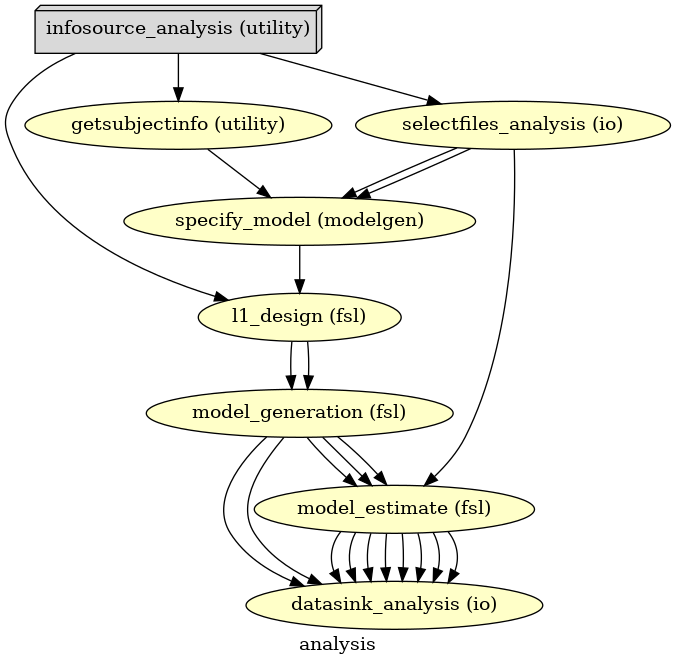

In [50]:
# Create analysis output graph
analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(analysis.base_dir, 'analysis', 'graph.png'))

In [51]:
analysis.run('MultiProc', plugin_args={'n_procs': 2})

210303-10:13:10,782 nipype.workflow INFO:
	 Workflow analysis settings: ['check', 'execution', 'logging', 'monitoring']
210303-10:13:10,835 nipype.workflow INFO:
	 Running in parallel.
210303-10:13:10,838 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 20 jobs ready. Free memory (GB): 13.96/13.96, Free processors: 2/2.
210303-10:13:10,908 nipype.workflow INFO:
	 [Job 0] Cached (analysis.getsubjectinfo).
210303-10:13:10,931 nipype.workflow INFO:
	 [Node] Setting-up "analysis.selectfiles_analysis" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/analysis/_subject_id_10/selectfiles_analysis".
210303-10:13:10,947 nipype.workflow INFO:
	 [Node] Running "selectfiles_analysis" ("nipype.interfaces.io.SelectFiles")
210303-10:13:10,952 nipype.workflow INFO:
	 [Node] Finished "analysis.selectfiles_analysis".
210303-10:13:12,845 nipype.workflow INFO:
	 [Job 1] Completed (analysis.selectfiles_analysis).
210303-10:13:12,857 nipype.workflow INFO:
	 [MultiProc] Running 0 

210303-10:17:45,109 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 17 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * analysis.model_estimate
210303-10:17:45,179 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.datasink_analysis".
210303-10:17:45,183 nipype.workflow INFO:
	 [Node] Setting-up "analysis.datasink_analysis" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/analysis/_subject_id_09/datasink_analysis".
210303-10:17:45,184 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.datasink_analysis".
210303-10:17:45,189 nipype.workflow INFO:
	 [Node] Running "datasink_analysis" ("nipype.interfaces.io.DataSink")
210303-10:17:45,403 nipype.workflow INFO:
	 [Node] Finished "analysis.datasink_analysis".
210303-10:17:47,110 nipype.workflow INFO:
	 [Job 13] Completed (analysis.datasink_analysis).
210303-10:17:47,111 nipype.workflow INFO:
	 [MultiPro

210303-10:18:05,198 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.model_generation".
210303-10:18:05,205 nipype.workflow INFO:
	 [Node] Running "model_generation" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
210303-10:18:05,934 nipype.workflow INFO:
	 [Node] Finished "analysis.model_generation".
210303-10:18:07,130 nipype.workflow INFO:
	 [Job 25] Completed (analysis.model_generation).
210303-10:18:07,132 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 13 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * analysis.model_estimate
210303-10:18:07,194 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.model_estimate".
210303-10:18:07,196 nipype.workflow INFO:
	 [Node] Setting-up "analysis.model_estimate" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/analysis/_subject_id_07/model_estimate".
21

210303-10:22:35,507 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.l1_design".
210303-10:22:35,514 nipype.workflow INFO:
	 [Node] Setting-up "analysis.l1_design" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/analysis/_subject_id_05/l1_design".
210303-10:22:35,515 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.l1_design".
210303-10:22:35,539 nipype.workflow INFO:
	 [Node] Running "l1_design" ("nipype.interfaces.fsl.model.Level1Design")
210303-10:22:35,559 nipype.workflow INFO:
	 [Node] Finished "analysis.l1_design".
210303-10:22:37,400 nipype.workflow INFO:
	 [Job 38] Completed (analysis.l1_design).
210303-10:22:37,402 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 9 jobs ready. Free memory (GB): 13.76/13.96, Free processors: 1/2.
                     Currently running:
                       * analysis.model_estimate
210303-10:22:37,462 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.model_generat

210303-10:27:31,805 nipype.workflow INFO:
	 [Job 51] Cached (analysis.specify_model).
210303-10:27:31,805 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.model_generation".
210303-10:27:31,812 nipype.workflow INFO:
	 [Node] Running "model_generation" ("nipype.interfaces.fsl.model.FEATModel"), a CommandLine Interface with command:
feat_model run0 
210303-10:27:32,564 nipype.workflow INFO:
	 [Node] Finished "analysis.model_generation".
210303-10:27:33,697 nipype.workflow INFO:
	 [Job 46] Completed (analysis.model_generation).
210303-10:27:33,704 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 13.96/13.96, Free processors: 2/2.
210303-10:27:33,802 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.model_estimate".
210303-10:27:33,807 nipype.workflow INFO:
	 [Node] Setting-up "analysis.model_estimate" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/analysis/_subject_id_04/model_estimate".
210303

210303-10:31:59,965 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 13.96/13.96, Free processors: 2/2.
210303-10:32:00,55 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.l1_design".
210303-10:32:00,61 nipype.workflow INFO:
	 [Job 63] Cached (analysis.getsubjectinfo).
210303-10:32:00,61 nipype.workflow INFO:
	 [Node] Setting-up "analysis.l1_design" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/analysis/_subject_id_02/l1_design".
210303-10:32:00,62 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.l1_design".
210303-10:32:00,83 nipype.workflow INFO:
	 [Node] Running "l1_design" ("nipype.interfaces.fsl.model.Level1Design")
210303-10:32:00,102 nipype.workflow INFO:
	 [Node] Finished "analysis.l1_design".
210303-10:32:01,961 nipype.workflow INFO:
	 [Job 59] Completed (analysis.l1_design).
210303-10:32:01,967 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 2 jobs ready. Free memory (GB

210303-10:36:06,324 nipype.workflow INFO:
	 [Node] Outdated cache found for "analysis.datasink_analysis".
210303-10:36:06,329 nipype.workflow INFO:
	 [Node] Running "datasink_analysis" ("nipype.interfaces.io.DataSink")
210303-10:36:06,529 nipype.workflow INFO:
	 [Node] Finished "analysis.datasink_analysis".
210303-10:36:06,534 nipype.workflow INFO:
	 [Node] Finished "analysis.datasink_analysis".
210303-10:36:08,207 nipype.workflow INFO:
	 [Job 62] Completed (analysis.datasink_analysis).
210303-10:36:08,212 nipype.workflow INFO:
	 [Job 69] Completed (analysis.datasink_analysis).
210303-10:36:08,222 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.96/13.96, Free processors: 2/2.


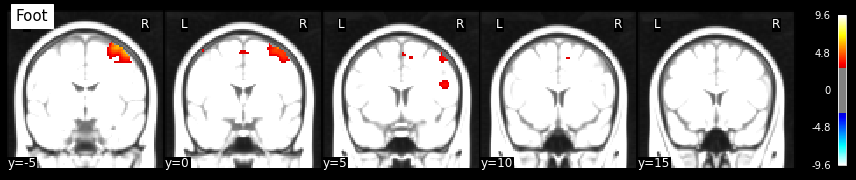

In [52]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = target_img

plot_stat_map('/home/analytic_variability_fmri/data/tutorial_data/datasink_fsl/results/estimate/_subject_id_01/tstat2.nii.gz', 
              title='Foot', bg_img=anatimg, threshold=3, display_mode='y', 
              cut_coords=(-5, 0, 5, 10, 15), dim=-1);

In [31]:
plot_stat_map('/home/analytic_variability_fmri/data/tutorial_data/datasink_fsl/results/estimate/_subject_id_01/zfstat1.nii.gz', 
              title='Activation', bg_img=anatimg, threshold=3, display_mode='y', 
              cut_coords=(-5, 0, 5, 10, 15), dim=-1);